In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('../data/raw/data.csv')

# Convert TransactionStartTime to datetime
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0


In [2]:
# Calculate RFM metrics

# Define a snapshot date for Recency calculation
snapshot_date = df['TransactionStartTime'].max() + pd.DateOffset(days=1)

# Calculate Recency, Frequency, and Monetary values
rfm = df.groupby('CustomerId').agg({
    'TransactionStartTime': lambda x: (snapshot_date - x.max()).days,
    'TransactionId': 'count',
    'Value': 'sum'
}).rename(columns={
    'TransactionStartTime': 'Recency',
    'TransactionId': 'Frequency',
    'Value': 'Monetary'
})

rfm.head()

,Recency,Frequency,Monetary
CustomerId,,,
CustomerId_1,84,1,10000
CustomerId_10,84,1,10000
CustomerId_1001,90,5,30400
CustomerId_1002,26,11,4775
CustomerId_1003,12,6,32000


In [3]:
# Pre-process the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze the resulting clusters
cluster_analysis = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print(cluster_analysis)

   Cluster    Recency    Frequency      Monetary
0        0  61.877279     7.720196  8.973793e+04
1        1  12.715398    34.703720  2.247565e+05
2        2  23.250000  1104.500000  7.487659e+07


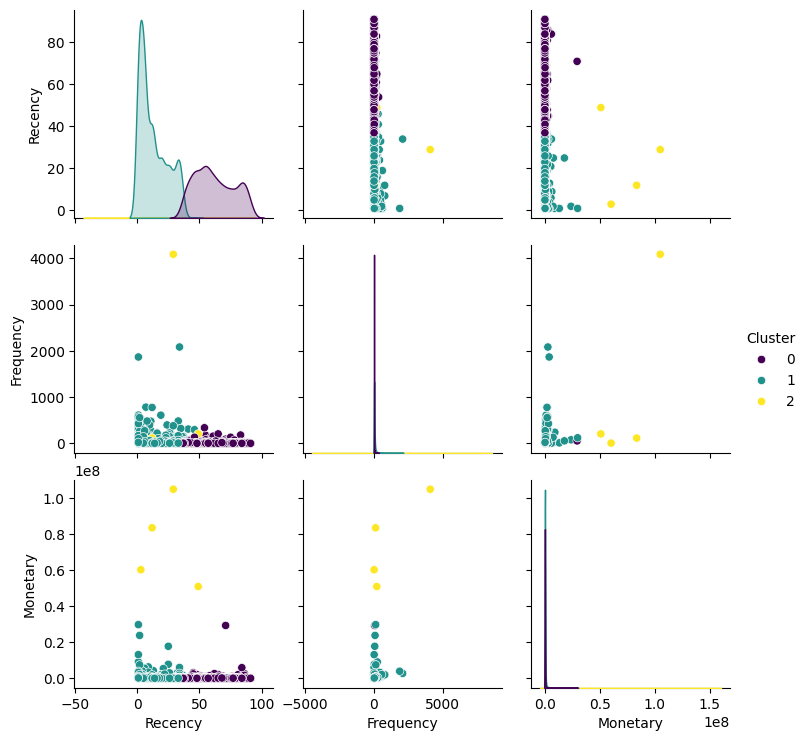

In [4]:
# Visualize the clusters
sns.pairplot(rfm, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'], palette='viridis')
plt.show()

In [5]:
# Identify the high-risk cluster (high Recency, low Frequency, low Monetary)
high_risk_cluster = rfm.groupby('Cluster')['Recency'].mean().idxmax()

# Create the target variable
rfm['is_high_risk'] = np.where(rfm['Cluster'] == high_risk_cluster, 1, 0)

print('High-risk cluster identified as:', high_risk_cluster)
print('\nValue counts for is_high_risk:')
print(rfm['is_high_risk'].value_counts())

High-risk cluster identified as: 0

Value counts for is_high_risk:
is_high_risk
0    2316
1    1426
Name: count, dtype: int64


In [6]:
# Merge the is_high_risk column back into a customer-level dataset
customer_risk_profiles = rfm.reset_index()

# Save the processed dataset
output_path = '../data/processed/customer_risk_profiles.csv'
customer_risk_profiles.to_csv(output_path, index=False)

print(f'Processed data saved to {output_path}')
customer_risk_profiles.head()

Processed data saved to ../data/processed/customer_risk_profiles.csv


,CustomerId,Recency,Frequency,Monetary,Cluster,is_high_risk
0,CustomerId_1,84,1,10000,0,1
1,CustomerId_10,84,1,10000,0,1
2,CustomerId_1001,90,5,30400,0,1
3,CustomerId_1002,26,11,4775,1,0
4,CustomerId_1003,12,6,32000,1,0
